# Python ML Labs project - Prediction of Stroke

Author: Samd Guizani

Cohort: A23 (SPOC)

## Problem Statement

The objective of the study is to propose a model that predicts whether a patient has stroke or not, based on descriptors (such as age, gender, existing discease, etc.)

The dataset contains the following variables:
1) **id**: unique patient identifier
2) **gender**: “Male”, “Female” or “Other”
3) **age**: age of the patient
4) **hypertension**: 0 (if the patient doesn’t have hypertension) or 1 (if the patient has hypertension)
5) **heart_disease**: 0 (if the patient doesn’t have a heart disease) or 1 (if the patient has a heart disease)
6) **ever_married**: “No” or “Yes”
7) **work_type**: “children”, “Govt_job”, “Never_worked”, “Private” or “Self-employed”
8) **Residence_type**: “Rural” or “Urban”
9) **avg_glucose_level**: average glucose level in the blood
10) **bmi**: body mass index
11) **smoking_status**: “formerly smoked”, “never smoked”, “smokes” or “Unknown” (in this case the information for the patient is not available)
12) **stroke**: 1 (if the patient had a stroke) or 0 (if the patient didn’t have a stroke)

**stroke** is the target variable to be predicted. It is a binary value (0 or 1), hence the model to develop is a ***classification*** model.

## Imports and loading dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_to_dataset = './Inputs/stroke_data.csv'
df = pd.read_csv(path_to_dataset, sep=',', index_col='id')

In [4]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [5]:
n, d = df.shape
print(f'Number of observations: {n}')
print(f'Number of variables: {d}')

Number of observations: 5110
Number of variables: 11


In [6]:
vars = df.columns
print('List of all variables:\n')
for i, c, in enumerate(vars):
    print(i, c)

List of all variables:

0 gender
1 age
2 hypertension
3 heart_disease
4 ever_married
5 work_type
6 Residence_type
7 avg_glucose_level
8 bmi
9 smoking_status
10 stroke


In [7]:
# Group variables in continuous and categorical
continuous_vars = df.columns[[1, 7, 8]]
categorical_vars = df.columns[[0, 2, 3, 4, 5, 6, 9, 10]]

# Display levels of categorical variables
for cat_var in categorical_vars:
    print(cat_var, df[cat_var].unique()) 

gender ['Male' 'Female' 'Other']
hypertension [0 1]
heart_disease [1 0]
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke [1 0]


## Exploratory Data Analysis

In [8]:
# Display count of NA values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Exploring univariate continuous variables

In [9]:
df[continuous_vars].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


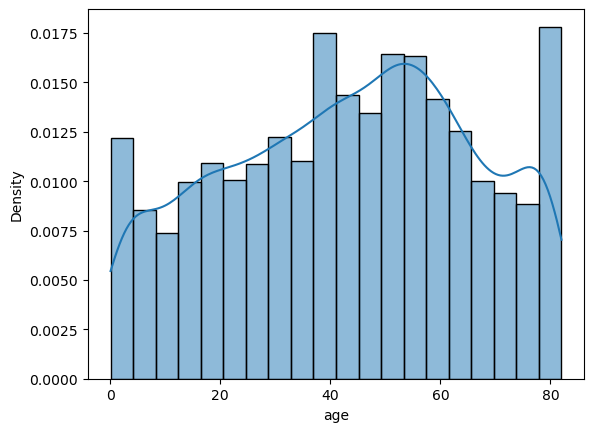

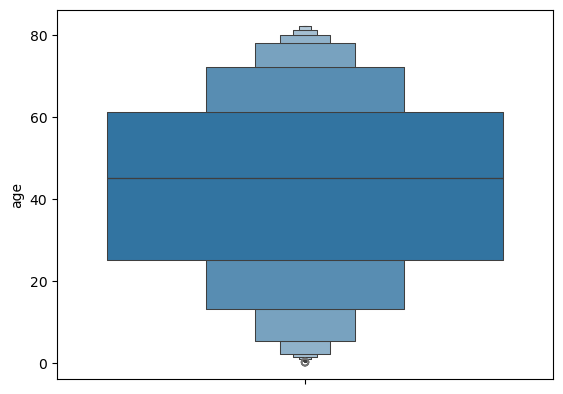

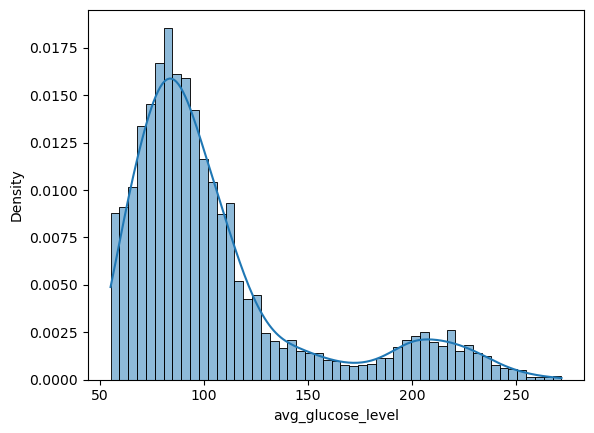

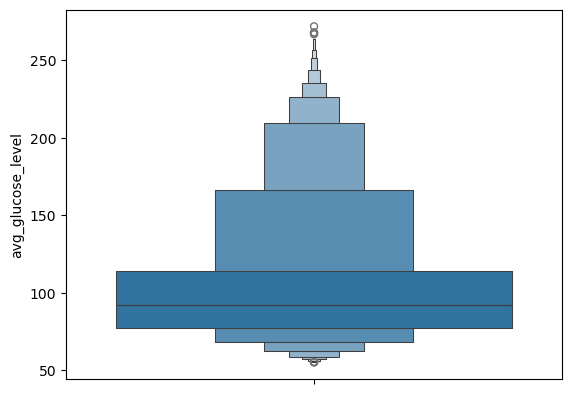

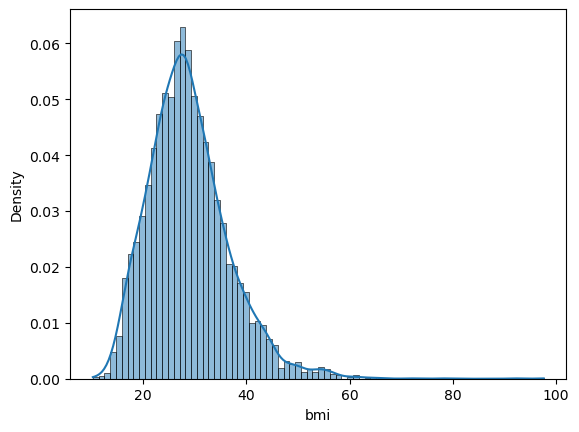

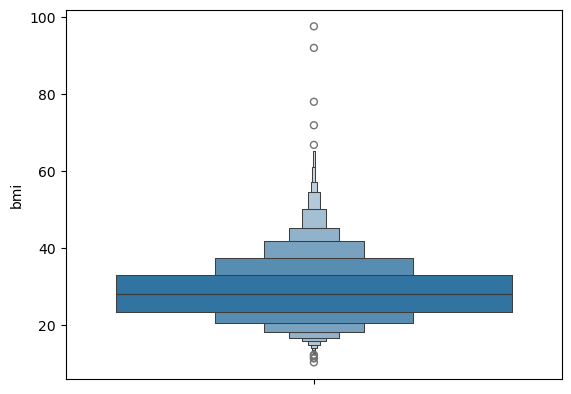

In [10]:
for cont_var in continuous_vars:
    plt.figure()
    sns.histplot(df[cont_var], kde=True, stat='density')
    plt.show()
    
    plt.figure()
    sns.boxenplot(df[cont_var])
    plt.show()

In [11]:
df.loc[(df.bmi >= 65) | (df.bmi <=15), :].sort_values(by='bmi')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
38043,Female,1.24,0,0,No,children,Rural,122.04,10.3,Unknown,0
3205,Female,79.00,0,0,Yes,Self-employed,Urban,79.03,11.3,Unknown,0
59993,Male,40.00,0,0,Yes,Private,Rural,60.96,11.5,never smoked,0
20364,Female,4.00,0,0,No,children,Urban,107.25,12.0,Unknown,0
45893,Female,8.00,0,0,No,children,Urban,106.51,12.3,Unknown,0
53924,Female,1.08,0,0,No,children,Urban,159.39,12.8,Unknown,0
41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
52859,Female,4.00,0,0,No,children,Urban,61.54,13.2,Unknown,0
31113,Female,1.16,0,0,No,children,Urban,86.00,13.3,Unknown,0


### Exploring univariate categorical varibales

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64 



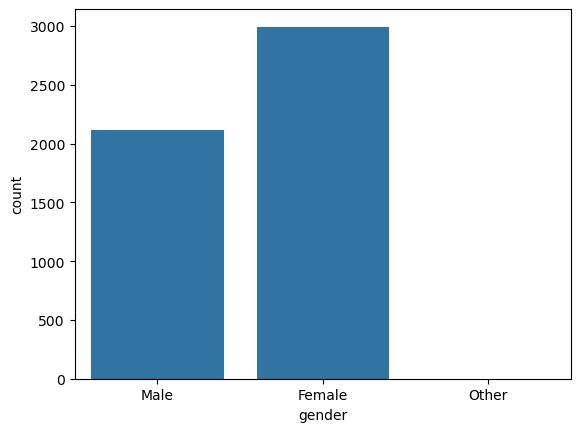

hypertension
0    4612
1     498
Name: count, dtype: int64 



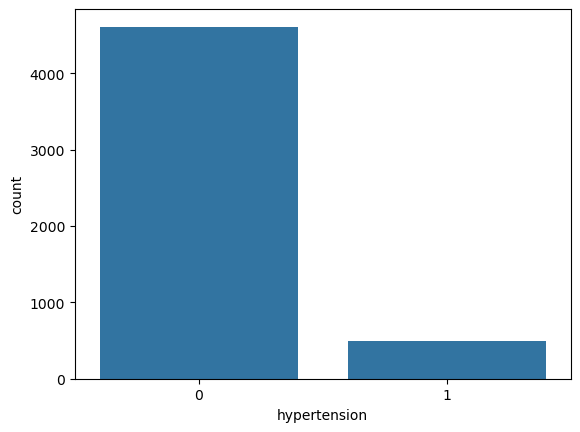

heart_disease
0    4834
1     276
Name: count, dtype: int64 



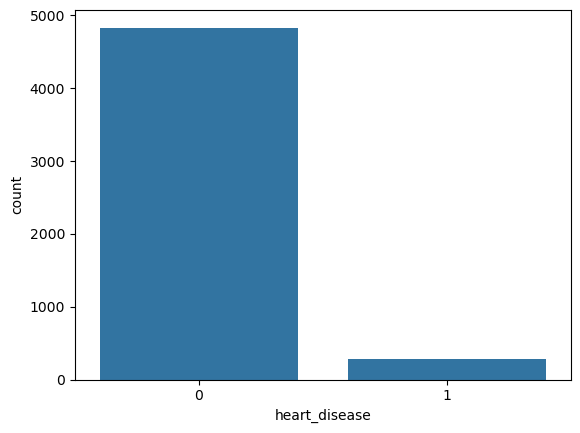

ever_married
Yes    3353
No     1757
Name: count, dtype: int64 



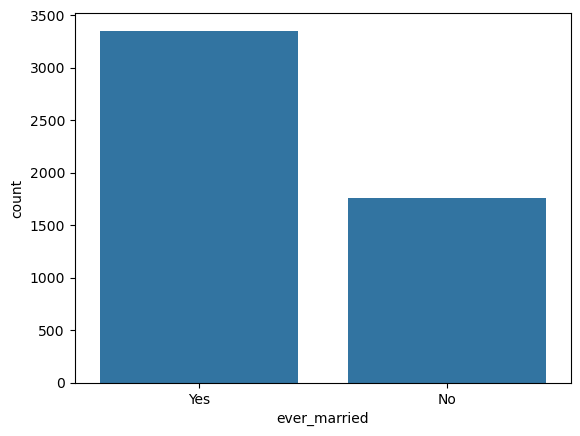

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64 



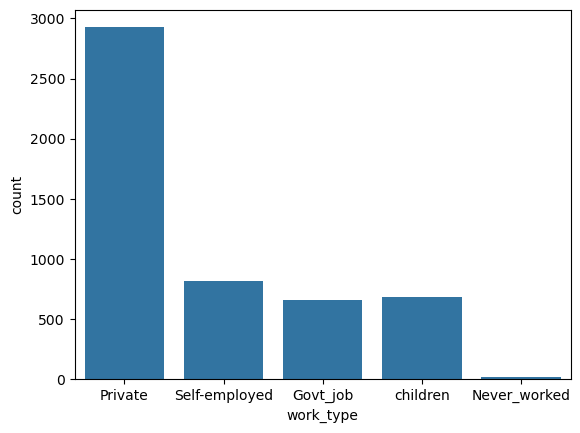

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64 



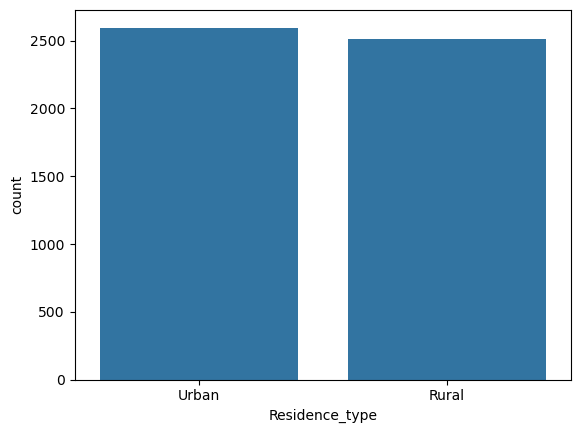

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64 



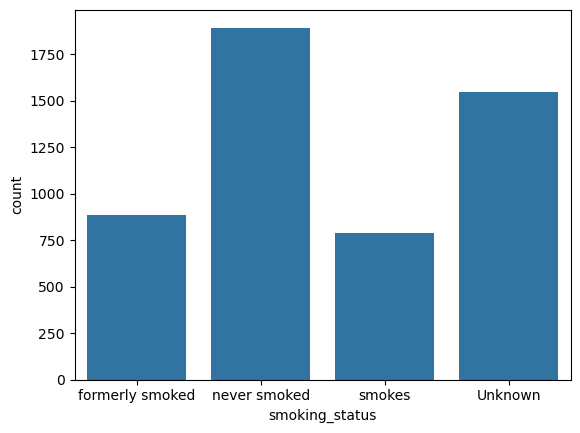

stroke
0    4861
1     249
Name: count, dtype: int64 



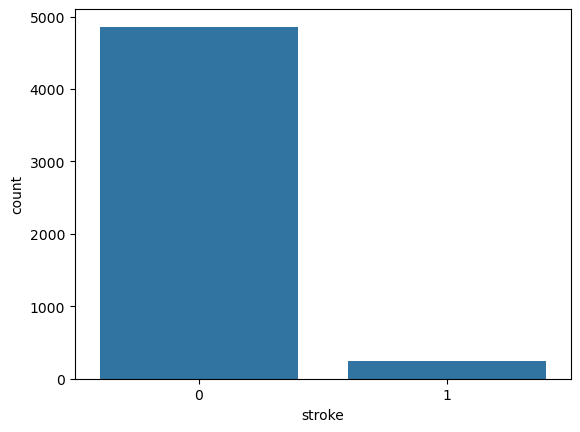

In [12]:
for cat_var in categorical_vars:
    print(df[cat_var].value_counts(), '\n')
    plt.figure()
    sns.countplot(df, x=cat_var)
    plt.show()

In [13]:
df.loc[df.gender == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [14]:
# Dropping 1 observation corresponding to gender == 'Other' (only one observation, no stroke)
df = df.drop(index=df.loc[df.gender == 'Other'].index)

df.shape

(5109, 11)

In [15]:
df.loc[df.work_type == 'Never_worked'].sort_values(by='age')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
34900,Male,13.0,0,0,No,Never_worked,Urban,85.08,14.6,Unknown,0
16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
57274,Male,14.0,0,0,No,Never_worked,Urban,137.91,41.8,never smoked,0
61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
69559,Male,15.0,0,0,No,Never_worked,Urban,64.29,16.7,Unknown,0
28461,Male,15.0,0,0,No,Never_worked,Rural,79.59,28.4,Unknown,0
23587,Female,16.0,0,0,No,Never_worked,Urban,84.40,25.9,never smoked,0


In [16]:
df.loc[df.work_type == 'children'].age.describe()

count    687.000000
mean       6.841339
std        4.533364
min        0.080000
25%        2.000000
50%        6.000000
75%       11.000000
max       16.000000
Name: age, dtype: float64

### Exploring multivariate relations

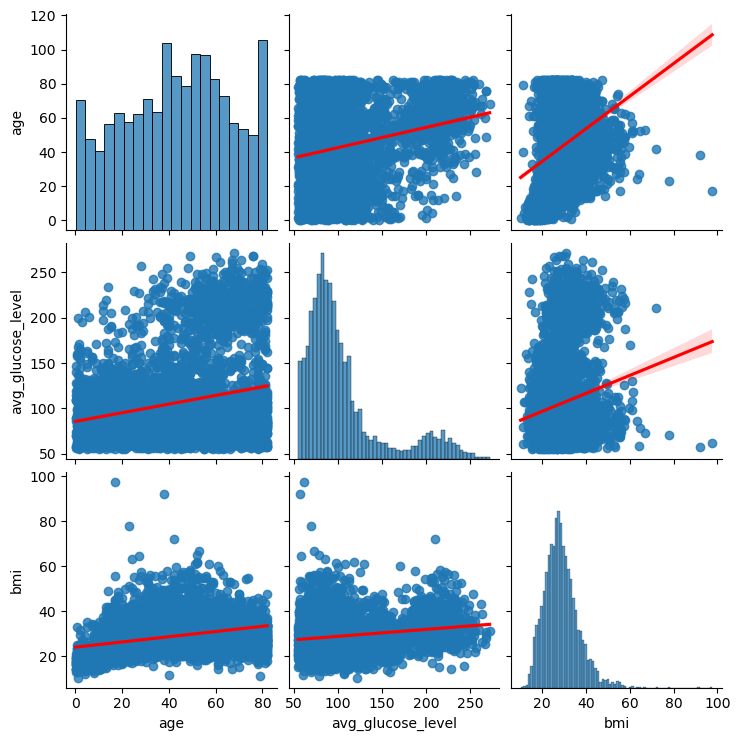

In [17]:
# Pairwise correlation between continuous variables
sns.pairplot(df[continuous_vars], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

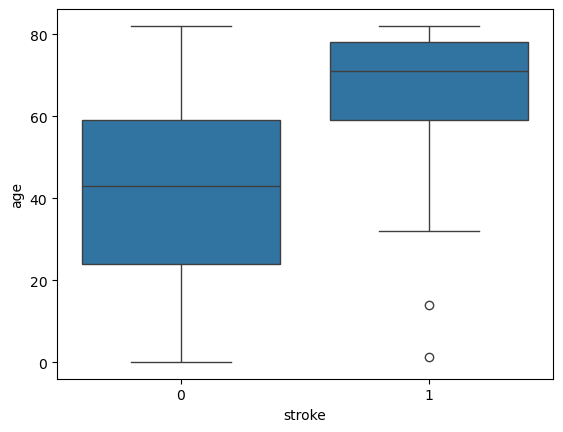

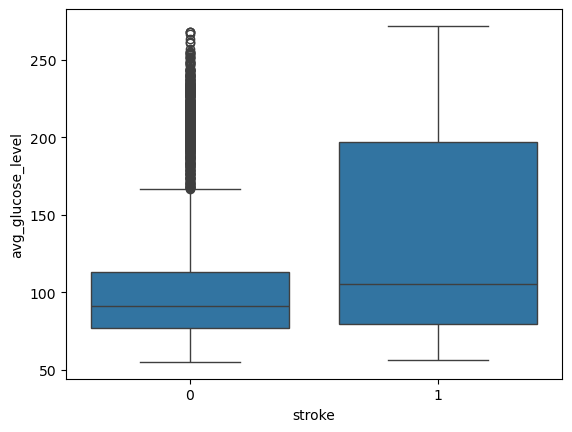

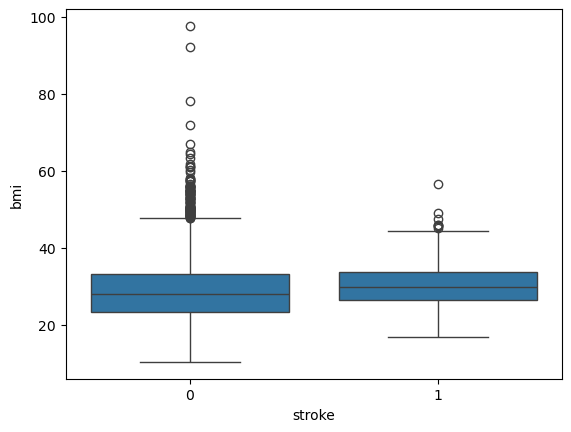

In [30]:
# Exploring correlation of continuous variables against target "stroke"
for cont_var in continuous_vars:
    plt.figure()
    sns.boxplot(df, x='stroke', y=cont_var)
    plt.show()

stroke         0         1
gender                    
Female  0.952906  0.047094
Male    0.948936  0.051064


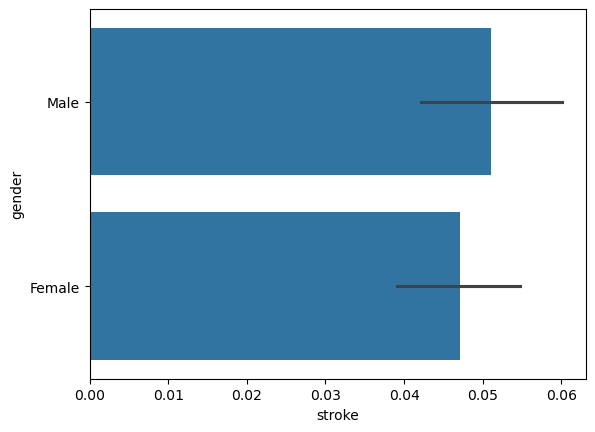

stroke               0         1
hypertension                    
0             0.960312  0.039688
1             0.867470  0.132530


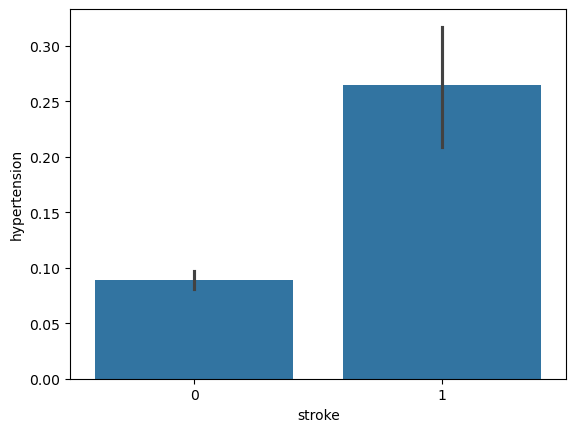

stroke                0         1
heart_disease                    
0              0.958204  0.041796
1              0.829710  0.170290


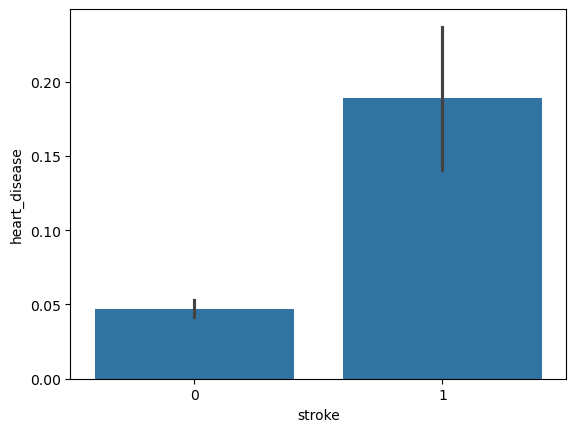

stroke               0         1
ever_married                    
No            0.983485  0.016515
Yes           0.934387  0.065613


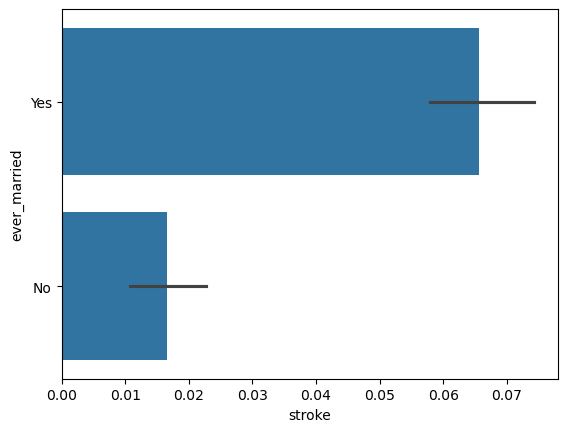

stroke                0         1
work_type                        
Govt_job       0.949772  0.050228
Never_worked   1.000000  0.000000
Private        0.949042  0.050958
Self-employed  0.920635  0.079365
children       0.997089  0.002911


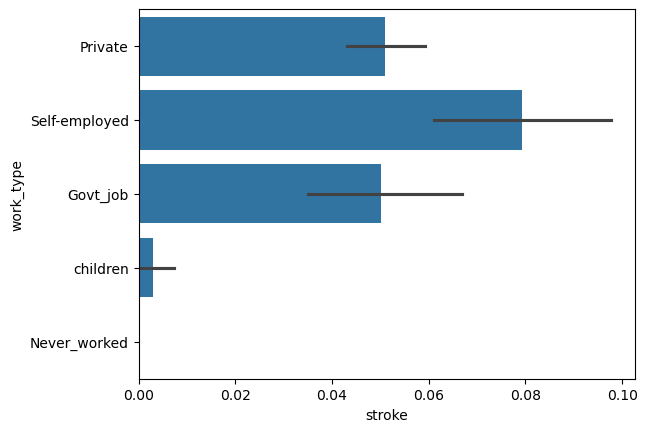

stroke                 0         1
Residence_type                    
Rural           0.954636  0.045364
Urban           0.947997  0.052003


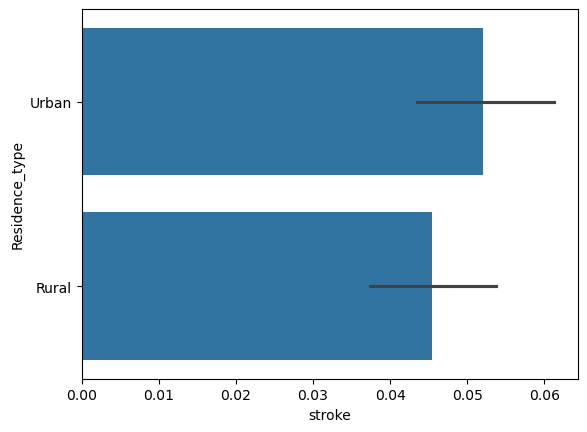

stroke                  0         1
smoking_status                     
Unknown          0.969560  0.030440
formerly smoked  0.920814  0.079186
never smoked     0.952431  0.047569
smokes           0.946768  0.053232


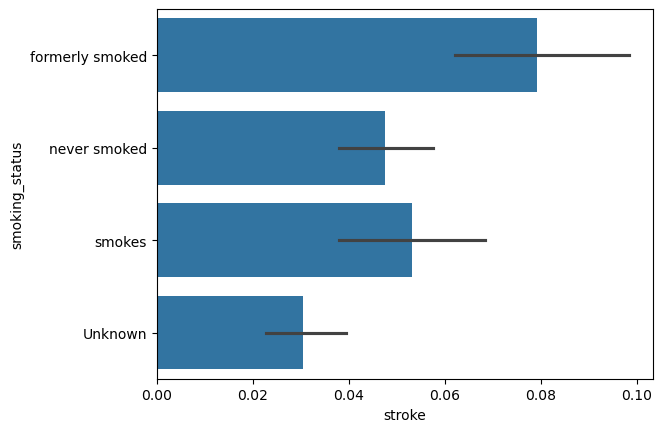

stroke    0    1
stroke          
0       1.0  0.0
1       0.0  1.0


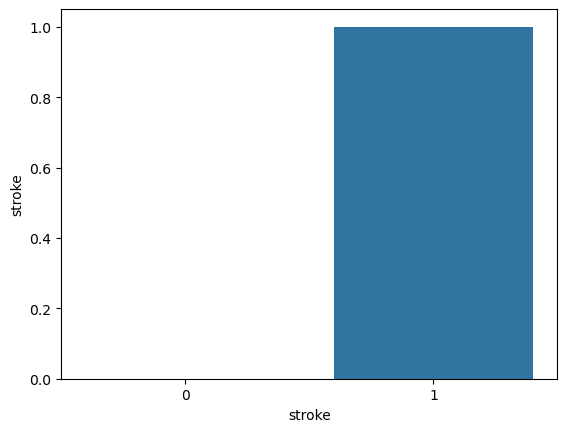

In [41]:
# Exploring pairwise correlations between categorical variables 
for cat_var in categorical_vars:
    contingency_table = pd.crosstab(df[cat_var], df['stroke'])
    print(contingency_table.div(contingency_table.sum(axis=1), axis=0)) # odds ratio
    plt.figure()
    sns.barplot(df, x='stroke', y=cat_var)
    plt.show()

In [58]:
df.loc[df.bmi.isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


In [46]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


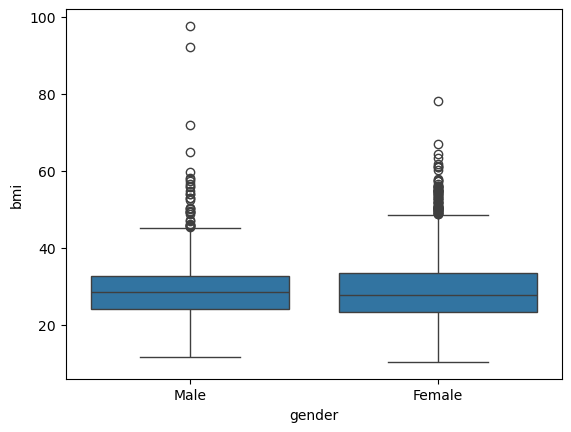

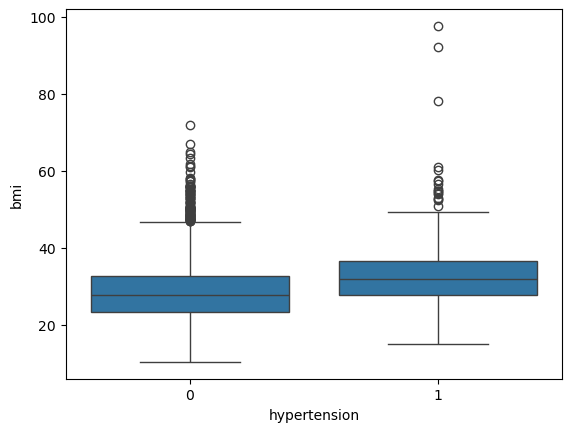

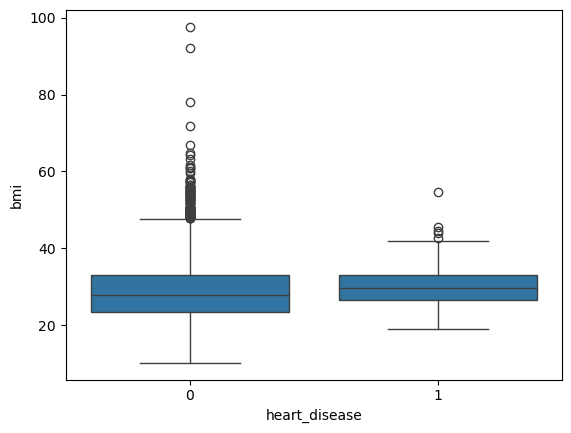

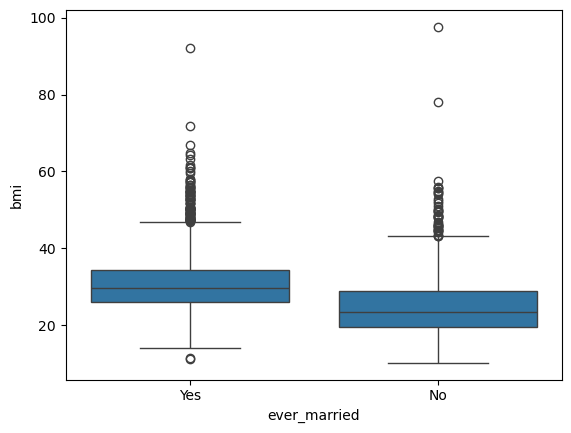

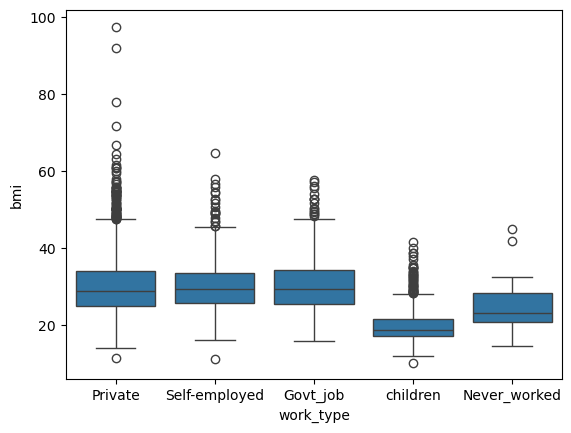

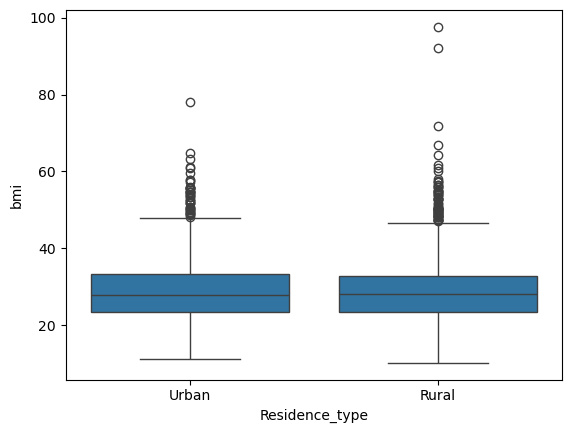

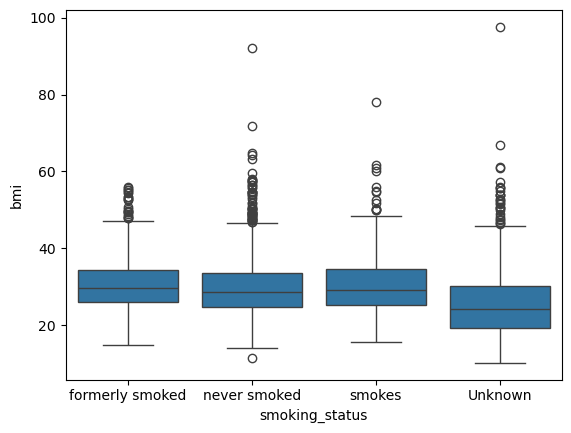

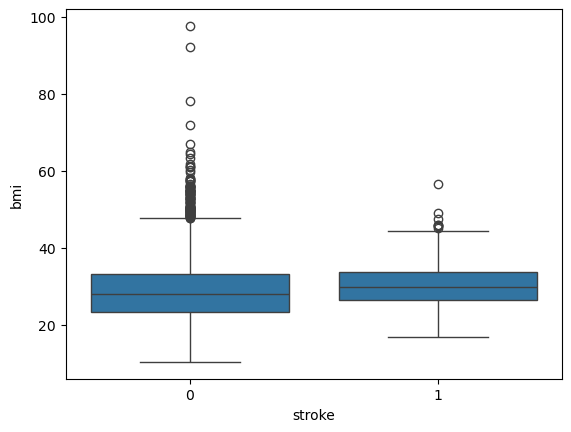

In [62]:
for cat_var in categorical_vars:
    plt.figure()
    sns.boxplot(df, x=cat_var, y='bmi')

## Features Engineering

In [107]:
df_preprocessed = df.copy(deep=True)

In [108]:
df_preprocessed.gender = pd.get_dummies(df.gender, drop_first=True)
df_preprocessed.ever_married = pd.get_dummies(df.ever_married, drop_first=True)
df_preprocessed.Residence_type = pd.get_dummies(df.Residence_type, drop_first=True)

df_preprocessed = pd.concat([df_preprocessed,pd.get_dummies(df_preprocessed.work_type, drop_first=True)],axis=1).drop(columns="work_type")
df_preprocessed = pd.concat([df_preprocessed,pd.get_dummies(df_preprocessed.smoking_status, drop_first=True)],axis=1).drop(columns="smoking_status")


In [109]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [110]:
df_preprocessed

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes
id,,,,,,,,,,,,,,,,
9046,True,67.0,0,1,True,True,228.69,36.6,1,False,True,False,False,True,False,False
51676,False,61.0,0,0,True,False,202.21,NaN,1,False,False,True,False,False,True,False
31112,True,80.0,0,1,True,False,105.92,32.5,1,False,True,False,False,False,True,False
60182,False,49.0,0,0,True,True,171.23,34.4,1,False,True,False,False,False,False,True
1665,False,79.0,1,0,True,False,174.12,24.0,1,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,False,80.0,1,0,True,True,83.75,NaN,0,False,True,False,False,False,True,False
44873,False,81.0,0,0,True,True,125.20,40.0,0,False,False,True,False,False,True,False
19723,False,35.0,0,0,True,False,82.99,30.6,0,False,False,True,False,False,True,False


In [130]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_preprocessed)
# X_test = df_preprocessed
# the model learns that the second feature is double the first
df_preprocessed_bmi_filled = pd.DataFrame(imp.transform(df_preprocessed), columns=df_preprocessed.columns, index=df_preprocessed.index)

In [131]:
df_preprocessed.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'Never_worked',
       'Private', 'Self-employed', 'children', 'formerly smoked',
       'never smoked', 'smokes'],
      dtype='object')

In [132]:
df_preprocessed_bmi_filled

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes
id,,,,,,,,,,,,,,,,
9046,1.0,67.0,0.0,1.0,1.0,1.0,228.69,36.600000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
51676,0.0,61.0,0.0,0.0,1.0,0.0,202.21,31.181948,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
31112,1.0,80.0,0.0,1.0,1.0,0.0,105.92,32.500000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,0.0,49.0,0.0,0.0,1.0,1.0,171.23,34.400000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1665,0.0,79.0,1.0,0.0,1.0,0.0,174.12,24.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18234,0.0,80.0,1.0,0.0,1.0,1.0,83.75,32.291054,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
44873,0.0,81.0,0.0,0.0,1.0,1.0,125.20,40.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
19723,0.0,35.0,0.0,0.0,1.0,0.0,82.99,30.600000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


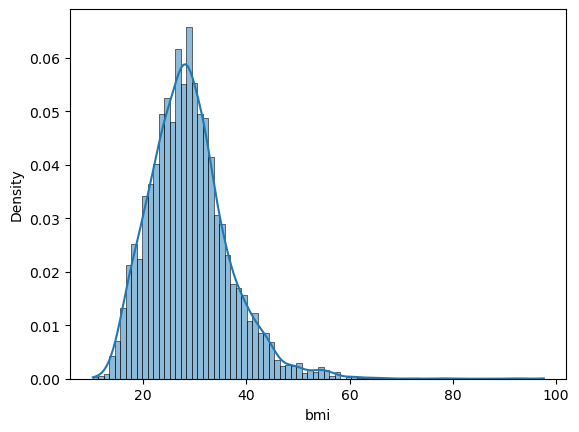

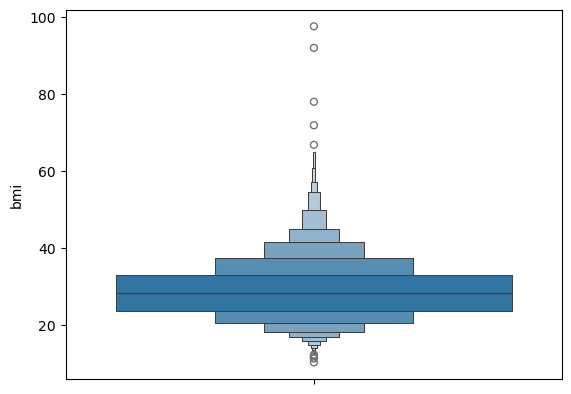

In [133]:
plt.figure()
sns.histplot(df_preprocessed_bmi_filled.bmi, kde=True, stat='density')
plt.show()

plt.figure()
sns.boxenplot(df_preprocessed_bmi_filled.bmi)
plt.show()

In [124]:
df.bmi.describe()

count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64

In [125]:
df_preprocessed_bmi_filled.bmi.describe()

count    5109.000000
mean       28.940245
std         7.731301
min        10.300000
25%        23.700000
50%        28.300000
75%        32.900000
max        97.600000
Name: bmi, dtype: float64